In [20]:
import os
os.environ["KERAS_BACKEND"] = "torch"
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import keras

if keras.backend.backend() == "torch":
    import torch
    print("Use torch backend")
    torch.autograd.set_grad_enabled(False)

import sys

current_dir = globals()['_dh'][0]
sys.path.append(os.path.join(current_dir, "../"))

import bayesflow as bf

import numpy as np

from custom_simulators import ParameterMask, RandomNumObs
from design_networks import RandomDesign, DeepAdaptiveDesign, EncoderNetwork, EmitterNetwork
from custom_dataset import DataSet
from experiment_1 import PolynomialRegression, PriorPolynomialReg
from diagnostics import plot_recovery

import pickle

Use torch backend


In [55]:
def get_data_for_plot_recovery(path, prior_samples, masks, n_sims = 2000, n_samples = 100, random = False):

    with open(os.path.join(path, 'arguments.pkl'), 'rb') as file:
        args_dict = pickle.load(file)

    inference_network = bf.networks.FlowMatching() # bf.networks.CouplingFlow()
    summary_network = bf.networks.DeepSet(summary_dim = args_dict["bf_summary_dim"])

    approximator = bf.approximators(
        inference_network = inference_network,
        summary_network = summary_network,
        inference_variables = ["params"],
        inference_conditions = ["masks", "n_obs"],
        summary_variables = ["outcomes", "designs"]
    )

    design_shape = torch.Size([1])
    mask_sampler = ParameterMask()
    prior_sampler = PriorPolynomialReg()
    random_num_obs_1 = RandomNumObs(min_obs = 1, max_obs = args_dict["T"])
    random_num_obs_2 = RandomNumObs(min_obs = 0, max_obs = args_dict["T"])

    random_design_generator = RandomDesign(design_shape = design_shape, min = args_dict["min_design"], max = args_dict["max_design"])

    model_1 = PolynomialRegression(mask_sampler = mask_sampler,
                                            prior_sampler = prior_sampler,
                                            tau_sampler = random_num_obs_1,
                                            design_generator = random_design_generator,
                                            sim_vars = {"sigma": args_dict["noise_size"]})

    encoder_net = EncoderNetwork(xi_dim = 1, y_dim = 1, hidden_dim = args_dict["dad_encoder_hidden_dim"], encoding_dim = args_dict["dad_summary_dim"])
    decoder_net = EmitterNetwork(input_dim = args_dict["dad_summary_dim"], hidden_dim = args_dict["dad_emitter_hidden_dim"], output_dim = 1, min = args_dict["min_design"], max = args_dict["max_design"]) # [B, summary_dim] -> [B, xi_dim]
    design_net = DeepAdaptiveDesign(encoder_net = encoder_net,
                                    decoder_net = decoder_net,
                                    design_shape = design_shape, 
                                    summary_variables=["outcomes", "designs"])
    
    model_2 = PolynomialRegression(mask_sampler = mask_sampler,
                                            prior_sampler = prior_sampler,
                                            tau_sampler = random_num_obs_2,
                                            design_generator = design_net,
                                            sim_vars = {"sigma": args_dict["noise_size"]}) # for design
    
    model_3 = PolynomialRegression(mask_sampler = mask_sampler,
                                            prior_sampler = prior_sampler,
                                            tau_sampler = random_num_obs_1,
                                            design_generator = design_net,
                                            sim_vars = {"sigma": args_dict["noise_size"]}) # for recovery

    batch_shape_b = torch.Size([args_dict["bf_batch_size"]])

    dataset = DataSet(batch_shape = batch_shape_b, 
                            joint_model_1 = model_1,
                            joint_model_2 = model_2,
                            joint_model_3 = model_3)
    
    dataset.set_stage(1)
    approximator.build_from_data(dataset.__getitem__(0))
        
    
    if args_dict["dad"] == "second":
        path_design_approximator = path + "/design_network.pt"
        state_dict = torch.load(path_design_approximator)["model_state_dict"]
        model_2.design_generator.load_state_dict(state_dict)

        if random:
            path_bf_weights_s1 = path + "/approximator_stage_1.weights.h5"
            approximator.load_weights(path_bf_weights_s1)
            test_sims = model_1.sample(torch.Size([n_sims]), tau = torch.tensor([args_dict["T"]]), masks = torch.tensor(masks), params = prior_samples)
            post_samples = approximator.sample((n_sims, n_samples), data = test_sims)["params"].to('cpu').numpy()
            return test_sims, post_samples
        
        else:
            path_bf_weights_s3 = path + "/approximator.weights.h5"
            approximator.load_weights(path_bf_weights_s3)
            test_sims = model_2.sample(torch.Size([n_sims]), tau = torch.tensor([args_dict["T"]]), masks = torch.tensor(masks), params = prior_samples)
            post_samples = approximator.sample((n_sims, n_samples), data = test_sims)["params"].to('cpu').numpy()
            return test_sims, post_samples
    else:
        path_design_approximator = path + "/design_network_stage_1.pt"
        state_dict = torch.load(path_design_approximator)["model_state_dict"]
        model_2.design_generator.load_state_dict(state_dict)
        path_bf_weights_s2 = path + "/approximator_stage_2.weights.h5"
        approximator.load_weights(path_bf_weights_s2)
        test_sims = model_2.sample(torch.Size([n_sims]), tau = torch.tensor([args_dict["T"]]), masks = torch.tensor(masks), params = prior_samples)
        post_samples = approximator.sample((n_sims, n_samples), data = test_sims)["params"].to('cpu').numpy()
        return test_sims, post_samples

In [1]:
mask = [[1., 1., 1., 1.]]
n_sims = 2000; n_samples = 100

# evaluate recovery and shannon entropy using same prior draws
prior_sampler = PriorPolynomialReg()
prior_samples = prior_sampler.sample(masks = torch.tensor(mask).repeat(n_sims, 1))
prior_single_sample = prior_samples[0].unsqueeze(0)

NameError: name 'PriorPolynomialReg' is not defined

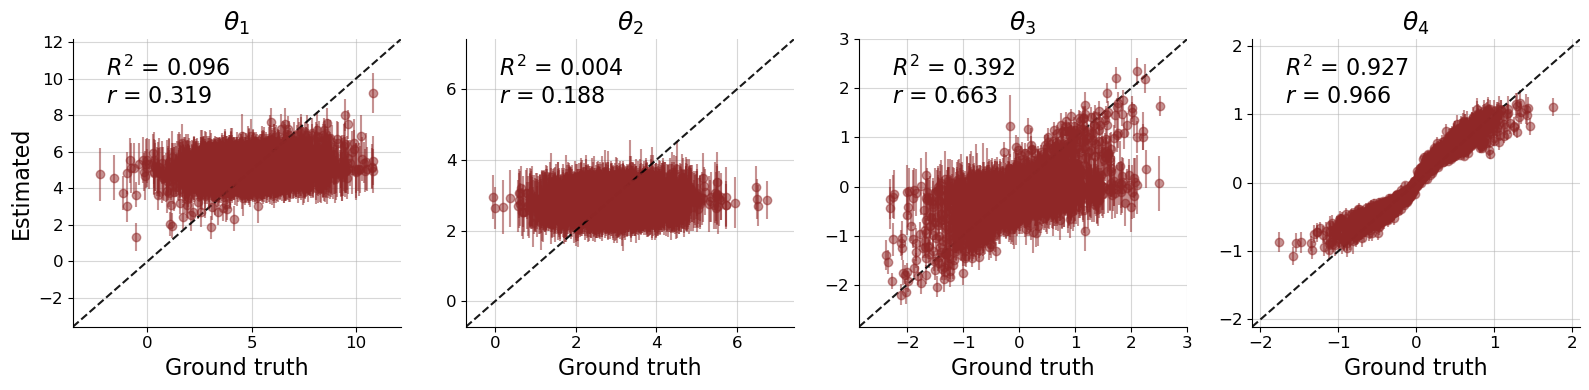

In [72]:
path_1 = "results/" + "dad_second_t_3_wider_design"
test_sims, post_samples = get_data_for_plot_recovery(path_1, prior_samples, masks = mask, random = True)
f = plot_recovery(post_samples, test_sims["params"].numpy(), point_agg = np.mean)

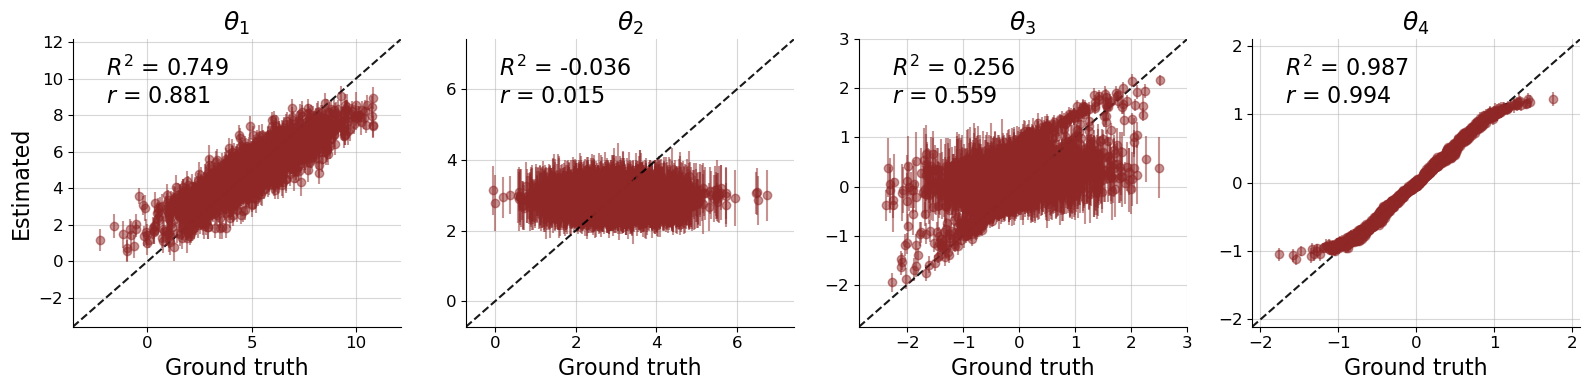

In [73]:
test_sims, post_samples = get_data_for_plot_recovery(path_1, prior_samples, masks = mask, random = False)
f = plot_recovery(post_samples, test_sims["params"].numpy(), point_agg = np.mean)

In [69]:
path_2 = "results/" + "dad_first_t_3_wider_design"

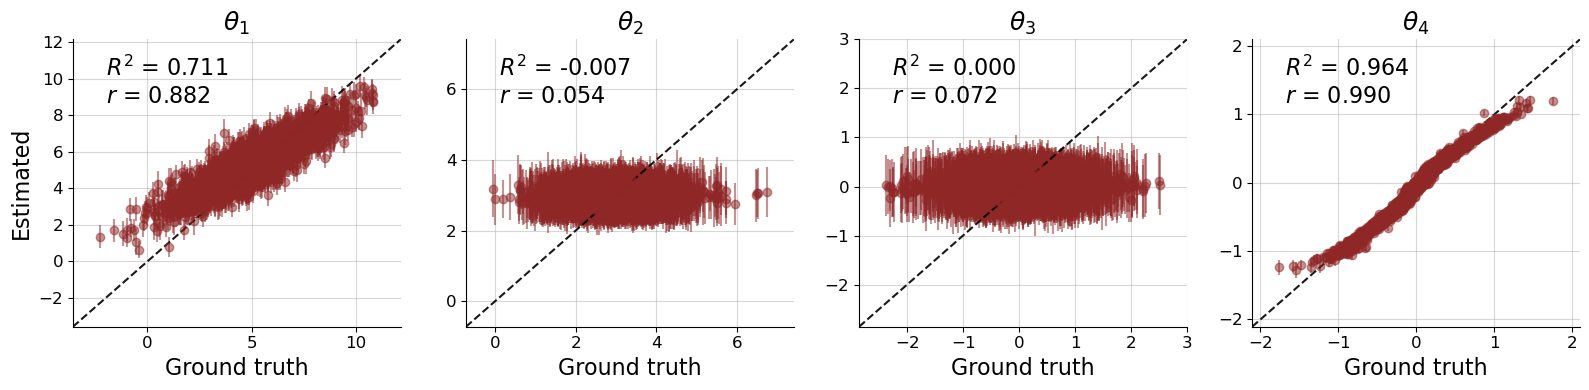

In [74]:
test_sims, post_samples = get_data_for_plot_recovery(path_2, prior_samples, masks = mask)
f = plot_recovery(post_samples, test_sims["params"].numpy(), point_agg = np.mean)